(ONAM)=

# 3.2 Algoritmos de descenso y búsqueda de línea para funciones convexas

```{admonition} Notas para contenedor de docker:

Comando de docker para ejecución de la nota de forma local:

nota: cambiar `<ruta a mi directorio>` por la ruta de directorio que se desea mapear a `/datos` dentro del contenedor de docker.

`docker run --rm -v <ruta a mi directorio>:/datos --name jupyterlab_optimizacion -p 8888:8888 -d palmoreck/jupyterlab_optimizacion:2.1.4`

password para jupyterlab: `qwerty`

Detener el contenedor de docker:

`docker stop jupyterlab_optimizacion`

Documentación de la imagen de docker `palmoreck/jupyterlab_optimizacion:2.1.4` en [liga](https://github.com/palmoreck/dockerfiles/tree/master/jupyterlab/optimizacion).

```

---

Nota generada a partir de [liga](https://drive.google.com/file/d/16-_PvWNaO0Zc9x04-SRsxCRdn5fxebf2/view).

```{admonition} Al final de esta nota el y la lectora:
:class: tip

* Comprenderá el uso de la información de primer y segundo orden para resolver problemas de minimización de funciones convexas mediante los algoritmos general de descenso y de búsqueda de línea por *backtracking*.

* Aprenderá la importancia y relación con ecuaciones no lineales al resolver los problemas que involucran aproximar mínimos locales de funciones.

```

## Ejemplos de problemas de optimización *small scale*

En optimización la búsqueda del (o los) **óptimo(s)** involucran el cálculo de información de primer o segundo orden, ver {ref}`Definición de función, continuidad y derivada <FCD>`, de la función $f_o$ de acuerdo a lo revisado en los {ref}`resultados útiles<RESUT>`. Tal información para problemas *small scale* es calculada utilizando todos los datos en un enfoque por *batch* o lote.

### Ejemplo

$$\displaystyle \min_{x \in \mathbb{R}^2} x_1^4+2x_1^2x_2+x_2^2$$

In [1]:
import numpy as np
import sympy
from sympy.tensor.array import derive_by_array
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.optimize import fmin
import pandas as pd
import cvxpy as cp

In [2]:
np.set_printoptions(precision=3, suppress=True)

Los candidatos a ser mínimos los encontramos al calcular el gradiente de $f_o$ que podemos calcular con *SymPy*

In [3]:
x1, x2 = sympy.symbols("x1, x2")

In [4]:
fo_sympy = x1**4+2*x1**2*x2+x2**2

In [5]:
sympy.pprint(fo_sympy)

  4       2        2
x₁  + 2⋅x₁ ⋅x₂ + x₂ 


In [6]:
gf = derive_by_array(fo_sympy, (x1, x2))

In [7]:
sympy.pprint(gf)

⎡    3                2       ⎤
⎣4⋅x₁  + 4⋅x₁⋅x₂  2⋅x₁  + 2⋅x₂⎦


y plantear:

$$
\nabla f_o(x) = 
\left [
\begin{array}{c}
4x_1^3+4x_1x_2\\
2x_1^2+2x_2
\end{array}
\right ]=0
$$

la cual es una ecuación de dos variables y dos incógnitas **no lineal**. Resolviendo para $x_2$ se obtiene la relación: $x_2 = -x_1^2$. Entonces todos los puntos con coordenadas $x = (x_1, x_2)$ que satisfacen tal relación cumplen $\nabla f_o(x) = 0$. ¿Todos serán mínimos locales?

**Gráfica de la superficie $f_o$**

In [8]:
def fo_numpy(x):
    return x[0]**4 + 2*x[0]**2*x[1] + x[1]**2

In [9]:
x1_plot,x2_plot = np.meshgrid(np.linspace(-2,2,100), np.linspace(-2,2,100))
z_plot = x1_plot**4 + 2*x1_plot**2*x2_plot + x2_plot**2

In [10]:
x1_np = 0
x2_np = 0 
z_np = fo_numpy([x1_np, x2_np])
point = (x1_np, x2_np, z_np)

In [11]:
print(point)

(0, 0, 0)


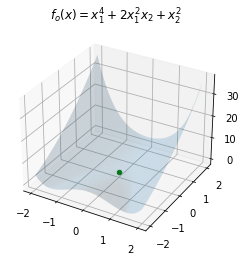

In [14]:
# Create the figure
fig = plt.figure()
# Add an axes
ax = fig.gca(projection='3d')
ax.plot_surface(x1_plot, x2_plot, z_plot, alpha=0.2)
ax.scatter(point[0], point[1], point[2], color='green')
plt.title("$f_o(x) = x_1^4+2x_1^2x_2+x_2^2$")
plt.show()

**Gráfica de las curvas de nivel de $f_o$**

In [13]:
x1_plot,x2_plot = np.meshgrid(np.linspace(-2,2,100), np.linspace(-4, 1,100))
z_plot = x1_plot**4 + 2*x1_plot**2*x2_plot + x2_plot**2

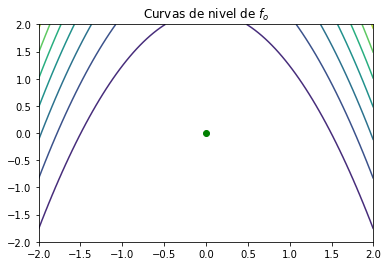

In [15]:
plt.contour(x1_plot,x2_plot,z_plot)
plt.scatter(point[0], point[1], color="green")
plt.title("Curvas de nivel de $f_o$")
plt.show()

Resolvamos con [scipy.optimize.fsolve](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fsolve.html#scipy.optimize.fsolve) la ecuación no lineal $\nabla f_o(x) = 0$

In [16]:
def eqn(x):
    x1,x2=x
    return [4*x1**3+4*x1*x2, 2*x1**2+2*x2]

```{margin}

Elegimos diferentes puntos iniciales.

```

In [17]:
root1 = fsolve(eqn, (1, 1))

In [18]:
root2 = fsolve(eqn, (-1, 1))

In [19]:
root3 = fsolve(eqn, (2, 0))

In [20]:
dic_roots = {"root1": root1,
             "root2": root2,
             "root3": root3}

```{margin}

Obsérvese que los puntos `root1`, `root2`, `root3` satisfacen la relación $x_2 = -x_1^2$. 

```


In [21]:
print(pd.DataFrame(dic_roots))

   root1  root2  root3
0    1.0   -1.0    2.0
1   -1.0   -1.0   -4.0


Al evaluar el gradiente en cada punto obtenemos cero (o cercano a cero):

In [22]:
gf_eval = lambda x: np.array([partial_derivative.subs({"x1": x[0], 
                                                       "x2": x[1]}) for partial_derivative in gf],
                             dtype=float)

In [23]:
dic = {"root1": gf_eval(root1),
       "root2": gf_eval(root2),
       "root3": gf_eval(root3)}

```{margin}

Los puntos `root1`, `root2` y `root3` resuelven la ecuación no lineal $\nabla f(x) = 0$ .

```

In [24]:
print(pd.DataFrame(dic).round(3))

   root1  root2  root3
0    0.0    0.0    0.0
1    0.0   -0.0    0.0


**¿Cómo podemos identificar si son mínimos? ...** usamos la Hessiana de $f_o$

In [25]:
Hf = derive_by_array(gf, (x1, x2))

In [26]:
sympy.pprint(Hf)

⎡     2             ⎤
⎢12⋅x₁  + 4⋅x₂  4⋅x₁⎥
⎢                   ⎥
⎣    4⋅x₁        2  ⎦


y revisamos eigenvalores de la Hessiana evaluada en los puntos `root1`, `root2`, `root3`

In [27]:
Hf_eval = lambda x: np.array([second_partial_derivative.subs({"x1": x[0], 
                                                              "x2": x[1]}) for second_partial_derivative in Hf],
                             dtype=float)

In [28]:
Hf_root1 = Hf_eval(root1)
Hf_root2 = Hf_eval(root2)
Hf_root3 = Hf_eval(root3)

```{margin}

La Hessiana en `root1` es semidefinida positiva por lo que no podemos concluir que sea mínimo local de $f$.

```

In [29]:
print(np.linalg.eigvals(Hf_root1))

[10.  0.]


```{margin}

La Hessiana en `root2` es semidefinida positiva por lo que no podemos concluir que sea mínimo local de $f$.

```

In [30]:
print(np.linalg.eigvals(Hf_root2))

[10. -0.]


```{margin}

La Hessiana en `root3` es semidefinida positiva por lo que no podemos concluir que sea mínimo local de $f$.

```

In [31]:
print(np.linalg.eigvals(Hf_root3))

[34.  0.]


Tenemos un criterio para $2$ dimensiones:

```{admonition} Comentario

Sea $f \in \mathcal{C}^2(\text{intdom}f)$, $\det(\nabla^2 f(x))$ determinante de la Hessiana y $x \in \mathbb{R}^2$ un punto crítico o estacionario de $f$:

* Si $\frac{\partial^2f(x)}{\partial x_1^2} < 0$ y $\det(\nabla^2 f(x)) >0$ entonces $f$ tiene un **máximo local** en $x$.

* Si $\frac{\partial^2f(x)}{\partial x_1^2} > 0$ y $\det(\nabla^2 f(x)) >0$ entonces $f$ tiene un **mínimo local** en $x$.

* Si $\det(\nabla^2 f(x)) < 0$ entonces $f$ tiene un **punto silla o [*saddle point*](https://en.wikipedia.org/wiki/Saddle_point)** en $x$.

* Si $\det(\nabla^2 f(x)) = 0$ no podemos concluir si $x$ es extremo.

```

```{admonition} Observaciones
:class: tip

* Al determinante de la Hessiana de $f$ se le nombra **Hessiano** de $f$.

* Lo anterior es un caso particular de los resultados descritos en {ref}`sobre puntos críticos <SPCRITICOS>`.

```

En el ejemplo el Hessiano es:

In [32]:
sympy.pprint(sympy.Matrix(Hf).det())

    2       
8⋅x₁  + 8⋅x₂


```{margin}

Los tres puntos `root1`, `root2` y `root3` satisfacen $x_2 = -x_1^2$.

```

El cual se anula justo en los puntos que cumplen: $x_2 = -x_1^2$

$8x_1^2 + 8x_2 = 8 x_1^2 + 8(-x_1^2) = 0$

por lo que no podemos concluir...

Usemos una función de *SciPy* [scipy.optimize.fmin](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin.html)

```{margin}

Elegimos un punto inicial.

```

In [33]:
res_fmin = fmin(fo_numpy, [1,1])

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 56
         Function evaluations: 110


```{margin}

El punto `res_fmin` satisface $\nabla f(x) = 0$ y la relación $x_2 = -x_1^2$.

```

In [34]:
print(res_fmin)

[-0.063 -0.004]


In [35]:
print(gf_eval(res_fmin))

[-0.  0.]


In [36]:
Hf_fmin = Hf_eval(res_fmin)

```{margin}

La Hessiana en `res_fmin` es semidefinida positiva por lo que no podemos concluir que sea mínimo local de $f$.

```

In [37]:
print(np.linalg.eigvals(Hf_fmin))

[0.    2.032]


Grafiquemos los puntos que cumplen $x_2=-x_1^2$

In [38]:
x1_plot,x2_plot = np.meshgrid(np.linspace(-2,2,100), np.linspace(-4,2,100))
z_plot = x1_plot**4 + 2*x1_plot**2*x2_plot + x2_plot**2

In [39]:
point1 = (root1[0], root1[1], fo_numpy(root1))
point2 = (root2[0], root2[1], fo_numpy(root2))
point3 = (root3[0], root3[1], fo_numpy(root3))
#another point:
point4 = (-2, -4, 0)

In [40]:
x1_plot2 = np.linspace(-2,2,100)

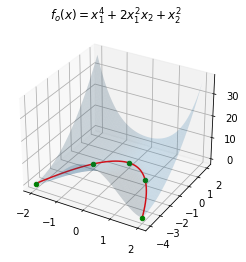

In [41]:
# Create the figure
fig = plt.figure()
# Add an axes
ax = fig.gca(projection='3d')
ax.plot_surface(x1_plot, x2_plot, z_plot, alpha=0.2)
ax.scatter(point[0], point[1], point[2], color='green')
ax.scatter(point1[0], point1[1], point1[2], color='green')
ax.scatter(point2[0], point2[1], point2[2], color='green')
ax.scatter(point3[0], point3[1], point3[2], color='green')
ax.scatter(point4[0], point4[1], point4[2], color='green')
ax.plot(x1_plot2, -x1_plot2**2, color="red")
plt.title("$f_o(x) = x_1^4+2x_1^2x_2+x_2^2$")
plt.show()

Evaluemos en un rango más amplio la función objetivo $f_o$ y realicemos una gráfica

In [42]:
x1_plot,x2_plot = np.meshgrid(np.linspace(-100,100,100), np.linspace(-100,100,100))
z_plot = x1_plot**4 + 2*x1_plot**2*x2_plot + x2_plot**2

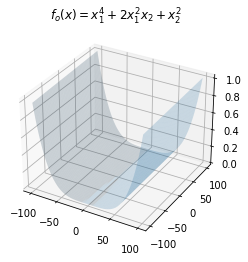

In [43]:
# Create the figure
fig = plt.figure()
# Add an axes
ax = fig.gca(projection='3d')
ax.plot_surface(x1_plot, x2_plot, z_plot, alpha=0.2)
plt.title("$f_o(x) = x_1^4+2x_1^2x_2+x_2^2$")
plt.show()

In [44]:
np.sum(z_plot < 0)

0

**El mínimo valor de $f_o$ es $0$ por lo que tenemos un conjunto de mínimos dados por la curva $x_2=-x_1^2$.**

### ¿Por qué fue un poco complicado determinar el conjunto de mínimos de $f_o$?

**$f_o(x)=x_1^4+2x_1^2x_2+x_2^2$ no es una función convexa en su $\text{dom}f_o$**, $\mathbb{R}^2$, esto es, no satisface la desigualdad:

$$f_o(\theta x + (1-\theta) y) \leq \theta f_o(x) + (1-\theta)f_o(y)$$

$\forall x,y$ en su dominio y $\forall \theta \in [0,1]$.

In [45]:
pointx = np.array([-.5, -1.5])
pointy = np.array([.5, -1.5])
theta = 1/2

In [46]:
point_convex_combination = theta*pointx + (1-theta)*pointy

In [47]:
print(fo_numpy(point_convex_combination))

2.25


```{margin}

Se tiene $f(\theta x + (1-\theta)y) > \theta f(x) + (1-\theta)f(y)$ con la elección $\theta=0.5$, $x=[-0.5, -1.5]^T$, $y=[0.5, -1.5]^T$ lo que indica que $f$ no es convexa sino cóncava para esta elección de puntos $x,y$.

```

In [48]:
print(theta*fo_numpy(pointx) + (1-theta)*fo_numpy(pointy))

1.5625


```{admonition} Observación
:class: tip

Recordar que si $f_o$ es una función convexa, el gradiente de $f_o$ nos ayuda a determinar si un punto es un mínimo local de forma necesaria y suficiente.

```

```{admonition} Ejercicio
:class: tip

Realizar un análisis similar al anterior para la función $f_o(x) = x_2^4+2x_2^2x_1^2+x_1^2$.

```

### Ejemplo importante

$$\displaystyle \min_{x \in \mathbb{R}^2} \frac{1}{2}x^TPx+q^Tx+r$$

donde: $P=\left [\begin{array}{cc} 5 & 4\\ 4 & 5 \end{array} \right ]$, $q=\left [\begin{array}{c} -1\\ 1 \end{array} \right]$, $r=3$.


Haciendo las multiplicaciones de matriz-vector y productos punto


In [49]:
P = sympy.Matrix([[5, 4],
                  [4, 5]])

In [50]:
x = sympy.Matrix(sympy.symbols("x1, x2"))

In [51]:
q = sympy.Matrix([-1,1])


In [52]:
fo_sympy = (1/2*x.T*P*x + q.T*x)[0] + 3

In [53]:
sympy.pprint(fo_sympy.expand())

      2                          2         
2.5⋅x₁  + 4.0⋅x₁⋅x₂ - x₁ + 2.5⋅x₂  + x₂ + 3


se **reescribe** el problema de optimización como:

$$\displaystyle \min_{x \in \mathbb{R}^2} \frac{5}{2}x_1^2 + \frac{5}{2}x_2^2+4x_1x_2 -x_1 + x_2+3$$ 

La función objetivo es una **función estrictamente convexa** en $\mathbb{R}^2$ (de hecho **fuertemente convexa**) pues:

```{margin}

Los eigenvalores de $P$ son $1$ y $9$ de multiplicidad simple cada uno.

```

In [54]:
sympy.pprint(P.eigenvals())

{1: 1, 9: 1}


y la Hessiana de $f_o$ es:

In [55]:
sympy.pprint(derive_by_array(derive_by_array(fo_sympy, (x1,x2)),
                             (x1,x2))
             )

⎡5.0  4.0⎤
⎢        ⎥
⎣4.0  5.0⎦


El gradiente de $f_o$ es:

In [56]:
sympy.pprint(fo_sympy.diff(x))

⎡5.0⋅x₁ + 4.0⋅x₂ - 1⎤
⎢                   ⎥
⎣4.0⋅x₁ + 5.0⋅x₂ + 1⎦


El mínimo debe satisfacer la ecuación **lineal** con dos variables y dos ecuaciones


$$\nabla f_o(x) = Px +q =\left [ \begin{array}{cc}
5 & 4\\
4 & 5
\end{array}
\right ]
\left [ \begin{array}{c}
x_1\\
x_2
\end{array}
\right ]
+ \left [ \begin{array}{c}
-1\\
1
\end{array}
\right ]=
\left [ \begin{array}{cc}
5x_1+4x_2-1\\
4x_1+5x_2+1
\end{array}
\right ]
=0
$$

```{admonition} Observación
:class: tip

En algunos casos especiales es posible resolver la ecuación no lineal $\nabla f_o(x) = 0$ para $x$ de forma analítica o cerrada. Este es el caso de este ejemplo cuya solución está dada por $x^* = -P^{-1}q$.

```

In [57]:
P=np.array([[5,4],[4,5]])
q=np.array([-1,1])
print(np.linalg.solve(P,-q))

[ 1. -1.]


El problema anterior también lo podemos resolver con [cvxpy](https://github.com/cvxgrp/cvxpy) pues es un **problema convexo** sin restricciones.

In [58]:
n = 2 #number of variables
x = cp.Variable(n) #optimization variable
fo_cvxpy = (1/2)*cp.quad_form(x, P) + q.T @ x #objective function

In [59]:
opt_objective = cp.Minimize(fo_cvxpy) #optimization objective

In [60]:
prob = cp.Problem(opt_objective) #optimization problem

In [61]:
print(prob.solve())

-0.9999999999999993


In [62]:
print("status:", prob.status)
print("optimal value", prob.value)
print("optimal var", x.value)

status: optimal
optimal value -0.9999999999999993
optimal var [ 1. -1.]


````{admonition} Observaciones
:class: tip

* El paquete cvxpy requiere que se especifique el problema de optimización a resolver siguiendo reglas establecidas en [Disciplined Convex Programming](https://dcp.stanford.edu/). En el ejemplo anterior resulta en un error si se ejecutan las líneas siguientes:

```python
x1 = cp.Variable()
x2 = cp.Variable()
fo = 2.5*x1**2 + 4*x1*x2 - x1 + 2.5*x2**2 + x2 + 3

obj = cp.Minimize(fo)

prob = cp.Problem(obj)

prob.solve()
```

La última línea produce

```
Problem does not follow DCP rules. Specifically: The objective is not DCP.
```

* En la liga de [ejemplos](https://www.cvxpy.org/examples/index.html) hay muchos problemas típicos en optimización convexa y en [Atomic Functions](https://www.cvxpy.org/tutorial/functions/index.html) ejemplos de funciones atómicas que pueden aplicarse a expresiones de CVXPY. 

````

```{admonition} Ejercicio
:class: tip

Utilizando las herramientas (teóricas y prácticas) del ejemplo anterior, resolver el problema de optimización:

$$\min_{x \in \mathbb{R}^2} ||Ax-b||_2^2$$

con $A=\left [ \begin{array}{ccc} 1 & 6 & 2.5\\ 1 & 2 & 8 \\ 1 & 10 & -1\\ 1 & -9 & 3\\ 1 & -1 & 2 \end{array} \right ]$, $b=\left [ \begin{array}{c} -1 \\ 0 \\ 2 \\ 3.5 \\ -1.7 \end{array} \right ]$.

```

## Métodos de descenso para funciones convexas

Los ejemplos anteriores mostraron la importancia de la información de primer y segundo orden de la función objetivo $f_o$ y las ecuaciones no lineales para resolver el problema de optimización. El primer ejemplo utilizó las funciones [scipy.optimize.fsolve](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fsolve.html#scipy.optimize.fsolve) y [scipy.optimize.fmin](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin.html) para este propósito. Tales funciones utilizan métodos iterativos para resolver ecuaciones no lineales y aproximar un mínimo local respectivamente en un esquema que satisface:

$$f(x^{(0)}) > f(x^{(1)}) > f(x^{(2)}) > \cdots > f(x^{(k)}) > \cdots$$

con $x^{(0)}$ punto inicial.

En lo siguiente se asume que $f_o$ cumple $f_o \in \mathcal{C}^2(\text{dom}f_o)$ y es convexa en un conjunto convexo y cerrado que contiene a $x^*$. Ver {ref}`conjunto abierto, cerrado, cerradura e interior <CACCI>` para definición de conjunto cerrado.

### Ejemplo de función objetivo convexa

Encontrar el mínimo del siguiente problema con un **método iterativo**.

$$\displaystyle \min_{x \in \mathbb{R}^4} (x_1-2)^2+(2-x_2)^2+x_3^2+x_4^4$$

In [63]:
x1, x2, x3, x4 = sympy.symbols("x1, x2, x3, x4")

In [64]:
fo_sympy = (x1-2)**2 + (2-x2)**2 + x3**2 + x4**4

In [65]:
gf = derive_by_array(fo_sympy, (x1, x2, x3, x4))

In [66]:
sympy.pprint(gf)

⎡                              3⎤
⎣2⋅x₁ - 4  2⋅x₂ - 4  2⋅x₃  4⋅x₄ ⎦


In [67]:
Hf = derive_by_array(gf, (x1, x2, x3, x4))

In [68]:
sympy.pprint(Hf)

⎡2  0  0    0   ⎤
⎢               ⎥
⎢0  2  0    0   ⎥
⎢               ⎥
⎢0  0  2    0   ⎥
⎢               ⎥
⎢              2⎥
⎣0  0  0  12⋅x₄ ⎦


Como $f_o$ es una función convexa (de hecho **estrictamente convexa**) en su dominio $\mathbb{R}^4$, se tiene que su óptimo se obtiene igualando y resolviendo la **ecuación no lineal** $\nabla f_o(x) = 0$ :

$$\nabla f_o(x) = 
\left[ \begin{array}{c}
2x_1-4 \\
2x_2-4\\
2x_3\\
4x_4^3
\end{array}
\right]
= 0
$$

El óptimo $x^* \in \mathbb{R}^4$ está dado por:

$$x^*=
\left[ \begin{array}{c}
2\\
2\\
0\\
0
\end{array}
\right]
$$

**¿Cómo encontramos numéricamente el óptimo con un método iterativo?**

### Métodos de descenso

Una gran cantidad de métodos para resolver problemas de optimización utilizan esquemas iterativos para calcular una **secuencia de minimización** de puntos $x^{(0)}, x^{(1)}, \dots \in \text{dom}f_o$ con la característica $f_o(x^{(k)}) \rightarrow p^*$ si $k \rightarrow \infty$. Tales métodos se conocen con el nombre de **métodos de descenso**.

```{margin}

Recuérdese que si $f_o$ es fuertemente convexa en el conjunto $\mathcal{S}$ entonces $\nabla^2 f_o (x) \in \mathbb{S}_{++}$ y $\text{cond}(\nabla ^2 f_o(x))$ está acotado por arriba por una constante para $x \in \mathcal{S}$.

```

```{admonition} Definición

Un método de descenso es aquel que genera la secuencia de minimización $x^{(0)}, x^{(1)}, \dots \in \text{dom}f_o$ la cual cumple con la desigualdad: $f_o(x^{(k+1)}) < f_o(x^{(k)})$ excepto para $x^{(k)}$ óptimo y $f_o(x^{(k)}) \rightarrow p^*$ si $k \rightarrow \infty$.

```

```{admonition} Comentario

En un esquema iterativo que produce secuencias de minimización se asume:

* Los puntos iniciales $x^{(0)}$ están en $\text{dom}f_o$.

* Que el conjunto $f_o(x^{(0)})$-subnivel sea cerrado pues así se garantiza que la secuencia de minimización está en el conjunto $f_o(x^{(0)})$-subnivel para todas las iteraciones.

* $f_o$ fuertemente convexa en el conjunto $f_o(x^{(0)})$-subnivel para tener propiedades dadas en los {ref}`resultados que son posibles probar para funciones fuertemente convexas <RESFFUERTCON>`. 

```

### Condición para que un paso o dirección de búsqueda sea de descenso

La idea de los métodos de optimización es calcular direcciones $\Delta x$ que sean de descenso, esto es que al movernos de un punto a otro en tal dirección, el valor de $f_o$ decrece:

<img src="https://dl.dropboxusercontent.com/s/25bmebx645howjw/direccion_de_descenso_de_Newton_1d.png?dl=0" heigth="600" width="600">

Tenemos muchas direcciones de descenso (de hecho infinitas) una que se muestra en el dibujo anterior, en el que $f = f_o$, $x^*$ es el óptimo de $f$ y $\hat{f}$ es un **modelo cuadrático**, es la dirección de descenso de Newton $\Delta x_{nt}$. Del punto $(x,f(x))$ nos debemos mover al punto $(x+\Delta x_{nt}, f(x + \Delta x_{nt}))$ para llegar al óptimo. En tal dirección $f$ decrece: $f(x+\Delta x_{nt}) < f(x)$.

Tenemos una condición para garantizar que una dirección sea de descenso. Geométricamente las direcciones de descenso forman un **ángulo agudo** con $-\nabla f_o(x^{(k)})$:

<img src="https://dl.dropboxusercontent.com/s/o3hypqiociye9jv/zone-for-descent-directions.png?dl=0" heigth="350" width="350">

En el dibujo $f = f_o$.

```{admonition} Definición

Si el paso o dirección de búsqueda satisface la condición: $\nabla f_o^T(x^{(k)})\Delta x^{(k)} < 0$ se le nombra **dirección de descenso**. 

```

```{admonition} Comentario

* La condición anterior funciona pues por el teorema de Taylor a primer order, ver {ref}`teorema de Taylor para una función $f: \mathbb{R}^n \rightarrow \mathbb{R}$ <TEOTAYLORNVARIABLES>`, se tiene:

$$f(x + \Delta x) = f(x) + \nabla f(x) ^T \Delta x$$

y si $\Delta x$ es dirección de descenso entonces: $f(x) + \nabla f(x) ^T \Delta x < f(x)$.


* Ejemplos de direcciones de descenso: 

    * $\Delta x = - \nabla f_o \left (x^{(k)} \right )$ que da lugar al método de descenso en gradiente para $x^{(k)}$ no óptimo.
    
    * $\Delta x = - \nabla^2 f_o \left (x^{(k)} \right )^{-1} \nabla f_o\left(x^{(k)} \right)$ que da lugar al método de descenso por Newton con $\nabla^2 f_o \left (x^{(k)} \right ) \in \mathbb{S}_{++}$ y $x^{(k)}$ no óptimo.

```

### Continuando con el ejemplo anterior

Encontrar el mínimo del siguiente problema.

$$\displaystyle \min_{x \in \mathbb{R}^4} (x_1-2)^2+(2-x_2)^2+x_3^2+x_4^4$$

**Opción descenso en gradiente**: usando el algoritmo con dirección de descenso el gradiente de $f_o$ sin búsqueda de línea se tiene: 

$$x^{(k+1)} = x^{(k)} - \nabla f_o(x^{(k)})$$

Tomando $x^{(0)} = \left [ \begin{array}{c} 5 \\ 5 \\1 \\ 0 \\ \end{array} \right ]$ como punto inicial:

In [69]:
x_0 = np.array([5,5,1,0])

In [70]:
gf_eval = lambda x: np.array([partial_derivative.subs({"x1": x[0], 
                                              "x2": x[1],
                                              "x3": x[2],
                                              "x4": x[3]}) for partial_derivative in gf],
                              dtype=float)

In [71]:
x_1 = x_0 - gf_eval(x_0)

In [72]:
print(x_1)

[-1. -1. -1.  0.]


In [73]:
x_2 = x_1 - gf_eval(x_1)

In [74]:
print(x_2)

[5. 5. 1. 0.]


In [75]:
x_3 = x_2 - gf_eval(x_2)

In [76]:
print(x_3)

[-1. -1. -1.  0.]


In [77]:
x_4 = x_3 - gf_eval(x_3)

In [78]:
print(x_4)

[5. 5. 1. 0.]


y aquí nos quedaremos ciclando hasta el infinito...

**Opción descenso por dirección de Newton:** usando el algoritmo con dirección de descenso de Newton de $f_o$ sin búsqueda de línea se tiene: 

$$x^{(k+1)} = x^{(k)} - \nabla^2 f_o \left (x^{(k)} \right )^{-1} \nabla f_o\left(x^{(k)} \right)$$

Tomando $x^{(0)} = \left [ \begin{array}{c} 5 \\ 5 \\1 \\ 0 \\ \end{array} \right ]$ como punto inicial y **no calculando la inversa** de la Hessiana pues en su lugar resolvemos el sistema de ecuaciones lineales $\nabla ^2 f_o \left ( x^{(k)} \right ) \Delta x = - \nabla f_o \left(x^{(k)}\right )$ resulta

In [79]:
x_0 = np.array([5,5,1,0])

In [80]:
Hf_eval = lambda x: np.array([second_partial_derivative.subs({"x1": x[0], 
                                                              "x2": x[1],
                                                              "x3": x[2],
                                                              "x4": x[3]}) for second_partial_derivative in Hf],
                             dtype=float)

In [81]:
Hf_sympy_eval = sympy.Matrix(Hf_eval(x_0))
sympy.pprint(Hf_sympy_eval)

⎡2.0  0.0  0.0  0.0⎤
⎢                  ⎥
⎢0.0  2.0  0.0  0.0⎥
⎢                  ⎥
⎢0.0  0.0  2.0  0.0⎥
⎢                  ⎥
⎣0.0  0.0  0.0  0.0⎦


In [82]:
gf_sympy_eval = sympy.Matrix(gf_eval(x_0))
sympy.pprint(gf_sympy_eval)

⎡6.0⎤
⎢   ⎥
⎢6.0⎥
⎢   ⎥
⎢2.0⎥
⎢   ⎥
⎣0.0⎦


In [83]:
x = sympy.Matrix([x1, x2, x3, x4])

El sistema de **ecuaciones lineales** a resolver es:

$$
\left [
\begin{array}{cccc}
2 & 0 & 0 & 0 \\
0 & 2 & 0 & 0 \\
0 & 0 & 2 & 0 \\
0 & 0 & 0 & 0
\end{array}
\right ]
\Delta x = 
-\left [
\begin{array}{c}
6 \\
6 \\
2 \\
0
\end{array}
\right ]
$$

**Obsérvese que la última ecuación es redundante**

In [84]:
sympy.pprint(sympy.solve(Hf_sympy_eval*x - (-gf_sympy_eval), x))

{x₁: -3.0, x₂: -3.0, x₃: -1.0}


$4a$ ecuación redundante y por tanto $x_4 = 0$

In [85]:
x_1 = x_0 + np.array([-3, -3, -1, 0])

In [86]:
print(x_1)

[2 2 0 0]


```{admonition} Comentarios

De acuerdo al ejemplo anterior:

* Utilizar información de primer o segundo orden nos ayuda a encontrar óptimo(s) de funciones.

* Encontrar al óptimo involucró un método iterativo.

* Con la información de primer orden no alcanzamos al óptimo (de hecho se cicla el método iterativo propuesto) pero con la de segundo orden sí lo alcanzamos en una iteración y tuvimos que resolver un sistema de ecuaciones lineales.


### Paso o dirección de búsqueda y tamaño o longitud de paso

La secuencia de minimización se obtiene con el esquema iterativo: $x^{(k+1)} = x^{(k)} + t^{(k)}\Delta x^{(k)}$. 

```{admonition} Definición

Al vector $\Delta x \in \mathbb{R}^n$ se le nombra **paso o dirección de búsqueda**. Al escalar $t^{(k)}$ se le nombra **tamaño o longitud de paso** y siempre es positivo salvo en el caso en que $x^{(k)}$ sea óptimo.
```

El valor $t^{(k)}$ se calcula con metodologías como búsqueda de línea o regiones de confianza, ver [line search](https://en.wikipedia.org/wiki/Line_search), [trust region](https://en.wikipedia.org/wiki/Trust_region) y en esta nota se revisa la búsqueda de línea con *backtracking*.

### Algoritmo: método general de descenso para funciones convexas

```{margin}

Los pasos de un algoritmo representan una guía para la implementación, no implica que se tengan que implementar uno a continuación del otro como se describe. Si una implementación respeta la lógica y al mismo algoritmo, entonces pueden seguirse los pasos de una forma distinta.
```

> **Dado** un **punto inicial** $x$ en $\text{dom}f_o$
>
> **Repetir** el siguiente bloque para $k=0,1,2,...$
>>
>> 1. Determinar una dirección de descenso $\Delta x$.
>> 2. Búsqueda de línea. Elegir un tamaño de paso $t > 0$.
>> 3. Hacer la actualización: $x = x + t\Delta x$.
>
> **hasta** convergencia (satisfacer criterio de paro).


```{margin}

Un rayo es el conjunto definido por $\{x + \theta v : \theta \geq 0 , v \neq 0, v \in \mathbb{R}^n\}$ para $x \in \mathbb{R}^n$.

<img src="https://dl.dropboxusercontent.com/s/l3z9j49ldzknmif/ej_rayo.png?dl=0" heigth="200" width="200">


```

```{admonition} Comentarios.

* El algoritmo termina si $f_o(x^{(k)})-p^* \leq \epsilon$ con $\epsilon >0$, esto es, $x^{(k)}$ es $\epsilon$-subóptimo.

* El criterio de paro típicamente es de la forma $||\nabla f_o(x)|| \leq tol$ donde: $tol$ es una cantidad pequeña y positiva (comúnmente menor o igual a $10^{-8}$). También se involucra el número máximo de iteraciones en el criterio de paro.

* El paso $2$ busca reducir $f_o$ lo **suficiente** o minimizarla aproximadamente a lo largo de un **rayo**. Uno de los métodos que permite de forma sencilla lo anterior es la **búsqueda de línea por [*backtracking*](https://en.wikipedia.org/wiki/Backtracking_line_search)**.

```

### Continuando con el ejemplo anterior

**Opción descenso en gradiente:** usando el algoritmo con dirección de descenso el gradiente de $f_o$ con búsqueda de línea se tiene:

$$x^{(k+1)} = x^{(k)} - t^{(k)}\nabla f_o(x^{(k)})$$

para $t^{(k)} > 0$. Con $t^{(0)}=0.5$ llegamos al óptimo en una iteración:

In [87]:
t_0=0.5

In [88]:
x_1 = x_0 - t_0*gf_eval(x_0)

In [89]:
print(x_1)

[2. 2. 0. 0.]


```{admonition} Observación 
:class: tip

El gradiente involucra menos almacenamiento en memoria que el almacenamiento de la Hessiana: $\mathcal{O}(n)$ vs $\mathcal{O}(n^2)$. 

```

**Opción usando cvxpy...**

In [90]:
x1 = cp.Variable()
x2 = cp.Variable()
x3 = cp.Variable()
x4 = cp.Variable()

In [91]:
fo_cvxpy = (x1 -2)**2 + (2-x2)**2 + x3**2 + x4**2



In [92]:
obj = cp.Minimize(fo_cvxpy)

prob = cp.Problem(obj)

print(prob.solve())

7.031418247836792e-48


In [93]:
print("status:", prob.status)
print("optimal value", prob.value)
print("optimal var", x1.value, x2.value, x3.value, x4.value)

status: optimal
optimal value 7.031418247836792e-48
optimal var 2.0 2.0 0.0 0.0


## Método de búsqueda de línea por *backtracking*

```{margin}

Ver [Backtracking_line_search](https://en.wikipedia.org/wiki/Backtracking_line_search).

```

En esta sección consideramos $f = f_o$. 

La idea del método de búsqueda de línea por *backtracking* es moverse de un punto a otro siguiendo una dirección de descenso con un tamaño de paso completo y si tal tamaño no satisface un criterio entonces realizar un *backtrack* de forma sistemática a lo largo de tal dirección hasta satisfacer el criterio resultando en el tamaño de paso correspondiente.

Para entender el método de búsqueda de línea por *backtracking* supóngase que $f$ tiene una forma siguiente:

<img src="https://dl.dropboxusercontent.com/s/0woqoj8foo5eco9/level_set_of_func.png?dl=0" heigth="300" width="300">


Y considérese una función $g: \mathbb{R} \rightarrow \mathbb{R}$ igual a $f$ pero restringida al rayo $x + t\Delta x$, esto es: $g(t) = f(x+t \Delta x)$ con $t>0$, $\Delta x$ dirección de descenso. Lo anterior se visualiza como sigue:

<img src="https://dl.dropboxusercontent.com/s/18udjmzmmd7drrz/line_search_backtracking_1.png?dl=0" heigth="300" width="300">

```{admonition} Observación
:class: tip

Obsérvese en el dibujo que $\nabla f(x) \neq 0$.

```

```{margin}

Ver {ref}`ejemplo<EJRestriccionALinea>` de la nota {ref}`Definición de función, continuidad y derivada <FCD>` para expresión de la derivada $g'(t)$.

```

Y como $f$ es continua y diferenciable, $g$ también lo es y $g(0)=f(x)$, $g'(t) = \nabla f(x+t\Delta x)^T \Delta x$. Si graficamos $g$ se tendría:

<img src="https://dl.dropboxusercontent.com/s/sgj7eqr2qysi8hs/line_search_backtracking_2.png?dl=0" heigth="300" width="300">


En la búsqueda de línea se construyen dos rectas. Una recta es $g(0) + \alpha g'(0)(t-0)$ con $\alpha \in (0,\frac{1}{2})$. La otra recta es $g(0)+g'(0)(t-0)$. Ambas rectas tienen pendiente negativa. Esto se visualiza como sigue:

<img src="https://dl.dropboxusercontent.com/s/11y008lq0fd6jl6/line_search_backtracking_3.png?dl=0" heigth="500" width="500">


En la búsqueda de línea por backtracking se busca $t^{(k)}$ tal que $f$ decrezca suficientemente. Lo anterior se establece con la desigualdad $f(x+t \Delta x) < f(x) + \alpha t \nabla f(x)^T \Delta x$:

<img src="https://dl.dropboxusercontent.com/s/o4f341x1y5sqxt8/line_search_backtracking_4.png?dl=0" heigth="500" width="500">


obsérvese en el dibujo anterior que la región en la que se elegirá $t^{(k)}$ está a la izquierda de la línea punteada vertical de color verde.

Y visualmente en $R^3$ se tiene:

<img src="https://dl.dropboxusercontent.com/s/t3yn7kkpd4il8hx/line_search_backtracking_5.png?dl=0" heigth="300" width="300">



El método depende de dos constantes $\alpha$ y $\beta$ con $\alpha \in (0,\frac{1}{2})$ y $\beta \in (0,1)$. 

### Algoritmo: búsqueda de línea por *backtracking*


> **Dados** $\Delta x$ dirección de descenso para $f$ en $x \in \text{dom}f$, $\alpha \in (0,\frac{1}{2})$, $\beta \in (0,1)$.
>
> **Asignar** t=1.
>
> **Mientras** $f(x+t\Delta x) > f(x) + \alpha t \nabla f(x) ^T\Delta x$.
>>
>> 1. **Reducir** $t: t= \beta t$.


```{admonition} Comentarios 

* El valor $\alpha$ típicamente se elige entre $.01$ y $.03$ que indica que se acepta un decrecimiento en el valor de $f$ entre el $1 \%$ y el $30 \%$. La constante $\beta$ comúnmente se elige entre $.1$ (que modifica fuertemente $t$) y $.8$ (que realiza una modificación menos drástica de $t$).

* Obsérvese que la multiplicación $\nabla f(x)^T \Delta x$ es una derivada direccional, ver {ref}`definición de función, continuidad y derivada <FCD>`.
```

## Función en Python para el método de *backtracking*

```python
def line_search_by_backtracking(f,dir_desc,x,
                                der_direct, alpha=.15, beta=.5):
    """
    Line search that sufficiently decreases f restricted to a ray in the direction dir_desc.
    Args:
        alpha (float): parameter in line search with backtracking, tipically .15
        beta (float): parameter in line search with backtracking, tipically .5
        f (lambda expression): definition of function f.
        dir_desc (array): descent direction.
        x (array): numpy array that holds values where line search will be performed.
        der_direct (float): directional derivative of f.
    Returns:
        t (float): positive number for stepsize along dir_desc that sufficiently decreases f.
    """
    t=1
    if alpha > 1/2:
        print("alpha must be less than or equal to 1/2")
        t=-1
    if beta>1:
        print("beta must be less than 1")
        t=-1;   
    if t!=-1:
        eval1 = f(x+t*dir_desc)
        eval2 = f(x) + alpha*t*der_direct
        while eval1 > eval2:
            t=beta*t
            eval1=f(x+t*dir_desc)
            eval2=f(x)+alpha*t*der_direct
    return t
```

```{admonition} Ejercicio
:class: tip

Realizar $5$ iteraciones para minimizar la función $log(e^{x_1^2} + e^{x_2^2})$ del método de descenso en gradiente utilizando búsqueda de línea tomando como punto inicial $(10,1)$ y calcular el error relativo de cada iteración. Para calcular $x^*$ utilizar [cvxpy](https://github.com/cvxgrp/cvxpy).

```

**Preguntas de comprehensión.**

1)¿Qué es un método de descenso?

2)Describe los elementos del esquema iterativo de un método de descenso.

3)¿Cuál es la condición matemática y geométrica que verifica que un paso de búsqueda sea de descenso?

4)(pregunta relacionada con *backtracking*)


**Referencias:**

1. S. P. Boyd, L. Vandenberghe, Convex Optimization, Cambridge University Press, 2009.


2. J. Dennis, R. B. Schnabel, Numerical Methods for Unconstrained Optimization and Nonlinear Equations, SIAM, 1996.

